This Notebook is for displaying results reproduced from TargetFinder using their data and suggested code on [Github](https://github.com/shwhalen/targetfinder)

We also added some other validation methods other than shuffling the data.

Shuffling the data creates highly overlapping testing and training data, which results in over-optimistic estimation of the performance.

In [1]:
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import clone
import os,sys
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.externals.joblib import Parallel, delayed
os.chdir("targetfinder-master/")
%matplotlib inline
import numpy as np
np.random.seed(0)
nonpredictors = ['enhancer_chrom', 'enhancer_start', 'enhancer_end', 'window_name',
                     'promoter_chrom', 'promoter_start', 'promoter_end', 
                     'window_chrom', 'window_start', 'window_end',
                     'active_promoters_in_window', 'interactions_in_window', 
                     'enhancer_distance_to_promoter', 'bin', 'label']

colors =  [
    (214, 39, 40), (255, 152, 150),    #redish
    (31, 119, 180), (174, 199, 232),   #blueish           
    (44, 160, 44), (152, 223, 138), #greenish
    (148, 103, 189), (197, 176, 213), #purple
    (255, 127, 14), (255, 187, 120),   #orangish
    (140, 86, 75), (196, 156, 148),    #brown
    (227, 119, 194), (247, 182, 210), #pink
    (127, 127, 127), (199, 199, 199),    #grey
    (188, 189, 34), (219, 219, 141),   #dark green
    (23, 190, 207), (158, 218, 229)  #bright blue
]
for i in range(len(colors)):
    colors[i] = (colors[i][0]/255., colors[i][1]/255., colors[i][2]/255.)
from itertools import combinations
from sklearn.utils import shuffle

In [2]:
import sklearn
sklearn.__version__
inch = 25.4
col1Width = 87 / inch

In [5]:
def load_data(cell):
    

    print(cell)
    training_df = pd.read_hdf('paper/targetfinder/{}/output-eep/training.h5'.format(cell), 
                              'training').set_index(['enhancer_name', 'promoter_name'])
    
    chrom_pos_counts = defaultdict(int)
    chrom_neg_counts = defaultdict(int)
    for x in training_df.index:
        temp = x[0].split(":")[0] + ':'
        if training_df.ix[x, 'label'] == 1:
            chrom_pos_counts[temp] += 1
        else:
            chrom_neg_counts[temp] += 1
    fig = plt.figure()
    ax = fig.add_subplot(111)
    map_to_int = {}
    for c in chrom_neg_counts.keys():
        print(c)
        try:
            a = int(c.strip(':').split('|')[1].strip('chr'))
            map_to_int[c] = a
        except:
            map_to_int[c] = ord(c.strip(':').split('|')[1].strip('chr'))
    chroms = sorted(list(chrom_pos_counts.keys()), key=lambda k:map_to_int[k])
    ax.plot([chrom_pos_counts[x] for x in chroms], "o", linewidth=0, label="pos_count")
    ax.plot([chrom_neg_counts[x] for x in chroms], "x", linewidth=0, label="neg_count")
    ax.set_xlim([-1, len(chroms)])
    ax.set_xticks(range(len(chroms)))
    ax.set_xticklabels(chroms, rotation=90)

    ax2 = ax.twinx()
    ax2.plot([chrom_neg_counts[x]*1.0 / chrom_pos_counts[x] for x in chroms], '^r', linewidth=0, label="ratio")

    ax2.set_ylabel('neg/pos ratio', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    ax.legend(loc="upper left")
    ax2.legend(loc="upper center")
    plt.show()
    
    predictors_df = training_df.drop(nonpredictors, axis = 1)
    labels = training_df['label']
    return predictors_df, labels, chrom_pos_counts, chrom_neg_counts

def get_random_score(predictors_df, labels):

    cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)
    tasks = []
    for train_idx, test_idx in cv.split(predictors_df, labels):
        train_data = predictors_df.ix[train_idx, :]
        test_data = predictors_df.ix[test_idx, :]
        train_labels = labels[train_data.index]
        test_labels = labels[test_data.index]
        
        tasks.append(delayed(_worker)(train_data, test_data, train_labels, test_labels))
    
    with Parallel(n_jobs=20) as parallel:
        results = parallel(tasks)    

    #print('{:2f} {:2f}'.format(scores.mean(), scores.std()))
    return results


def _worker(train_rows, val_rows, train_labels, val_labels, test_chroms=None):
    
    estimator1 = GradientBoostingClassifier(n_estimators = 4000, learning_rate = 0.1, 
                                           max_depth = 5, max_features = 'log2', random_state = 0)
    estimator1.fit(train_rows, train_labels)
    train_scores = np.zeros((estimator1.n_estimators,4), dtype=np.float64)
    scores = np.zeros((estimator1.n_estimators,4), dtype=np.float64)
    shuffled_scores = np.zeros((estimator1.n_estimators,4), dtype=np.float64)
    for i, (y_pred_train, y_pred, y_prob_train, y_prob) in enumerate(zip(estimator1.staged_predict(train_rows), 
                                                           estimator1.staged_predict(val_rows),
                                                           estimator1.staged_predict_proba(train_rows),
                                                           estimator1.staged_predict_proba(val_rows))):
        train_scores[i,:] = [f1_score(train_labels, y_pred_train), 
                             average_precision_score(train_labels, y_prob_train[:,1]),
                             roc_auc_score(train_labels, y_prob_train[:,1]),
                             accuracy_score(train_labels, y_pred_train)]
        scores[i,:] = [f1_score(val_labels, y_pred),
                       average_precision_score(val_labels, y_prob[:,1]),
                       roc_auc_score(val_labels, y_prob[:,1]),
                       accuracy_score(val_labels, y_pred)]
        shuffled_scores[i,:] = [f1_score(val_labels, shuffle(y_pred)),
                       average_precision_score(val_labels, shuffle(y_prob[:,1])),
                       roc_auc_score(val_labels, shuffle(y_prob[:,1])),
                       accuracy_score(val_labels, shuffle(y_pred))]
    return test_chroms, train_scores, scores, shuffled_scores

def get_split_score(predictors_df, labels, chrom_pos_counts, chrom_neg_counts):
    to_select_from = list(chrom_pos_counts.keys())
    np.random.shuffle(to_select_from)
    test_chrom_combs = []
    depth = 1
    while len(test_chrom_combs) < 100 and depth <= 6:
        print(depth)
        for temp_chroms in combinations(to_select_from, depth):
            #if abs(np.sum([chrom_pos_counts[c] for c in temp_chroms]) - np.sum(labels==1)//20) < np.sum(labels==1)//200:
            #    if abs(np.sum([chrom_neg_counts[c] for c in temp_chroms]) - np.sum(labels==0)//20) < np.sum(labels==0)//200:
            if (0.1 <= np.sum([chrom_pos_counts[c] for c in temp_chroms]) / np.sum(labels==1) <= 0.12 and  
               abs(np.sum([chrom_pos_counts[c] for c in temp_chroms]) / np.sum(labels==1)
                   - np.sum([chrom_neg_counts[c] for c in temp_chroms]) / np.sum(labels==0)) < 0.005): 
                    test_chrom_combs.append(temp_chroms)
                    #print(temp_chroms)
        depth += 1

    
    tasks = []
    test_chrom_combs = shuffle(test_chrom_combs)[:20]
    print(test_chrom_combs)
    for test_chroms in test_chrom_combs:

        test_data = predictors_df.ix[[i for i in predictors_df.index if (i[0].split(':')[0]+':') in test_chroms], :]
        train_data = predictors_df.ix[[i for i in predictors_df.index if (i[0].split(':')[0]+':') not in test_chroms], :]
        test_labels = labels[test_data.index]
        train_labels = labels[train_data.index]
        
        tasks.append(delayed(_worker)(train_data, test_data, train_labels, test_labels, test_chroms))
    
    with Parallel(n_jobs=20) as parallel:
        results = parallel(tasks)
    
    return results

def run_for_cell(cell):
    predictors_df, labels, chrom_pos_counts, chrom_neg_counts = load_data(cell)
    
    split_scores = get_split_score(predictors_df, labels, chrom_pos_counts, chrom_neg_counts)
    random_scores = get_random_score(predictors_df, labels)
    
    return random_scores, split_scores



In [6]:


cells = [ 'K562', 'GM12878','HeLa-S3', 'HUVEC', 'IMR90', 'NHEK']

K562
K562|chr16:
K562|chr17:
K562|chr20:
K562|chr8:
K562|chrX:
K562|chr14:
K562|chr5:
K562|chr12:
K562|chr6:
K562|chr18:
K562|chr10:
K562|chr1:
K562|chr19:
K562|chr7:
K562|chr15:
K562|chr9:
K562|chr21:
K562|chr3:
K562|chr13:
K562|chr4:
K562|chr2:
K562|chr11:
K562|chr22:


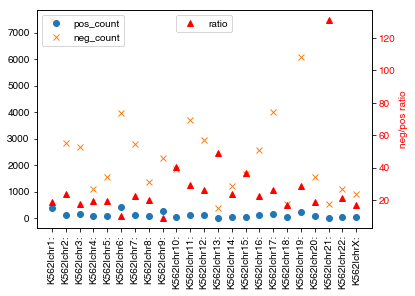

1
2
3
4
[('K562|chr21:', 'K562|chr5:', 'K562|chr20:', 'K562|chr3:'), ('K562|chr2:', 'K562|chrX:', 'K562|chr4:', 'K562|chr8:'), ('K562|chr7:', 'K562|chr5:', 'K562|chr20:', 'K562|chr18:'), ('K562|chr15:', 'K562|chr22:', 'K562|chrX:', 'K562|chr3:'), ('K562|chr21:', 'K562|chrX:', 'K562|chr20:', 'K562|chr3:'), ('K562|chr2:', 'K562|chr5:', 'K562|chrX:', 'K562|chr8:'), ('K562|chr22:', 'K562|chr5:', 'K562|chr4:', 'K562|chr16:'), ('K562|chr2:', 'K562|chr13:', 'K562|chr3:'), ('K562|chr5:', 'K562|chrX:', 'K562|chr4:', 'K562|chr16:'), ('K562|chr7:', 'K562|chr22:', 'K562|chrX:', 'K562|chr20:'), ('K562|chr2:', 'K562|chr5:', 'K562|chr18:', 'K562|chr8:'), ('K562|chrX:', 'K562|chr4:', 'K562|chr8:', 'K562|chr16:'), ('K562|chr13:', 'K562|chr18:', 'K562|chr3:', 'K562|chr16:'), ('K562|chr15:', 'K562|chrX:', 'K562|chr18:', 'K562|chr3:'), ('K562|chr21:', 'K562|chr5:', 'K562|chr3:', 'K562|chr8:'), ('K562|chr7:', 'K562|chrX:', 'K562|chr20:', 'K562|chr4:'), ('K562|chr21:', 'K562|chr14:', 'K562|chr3:', 'K562|chr

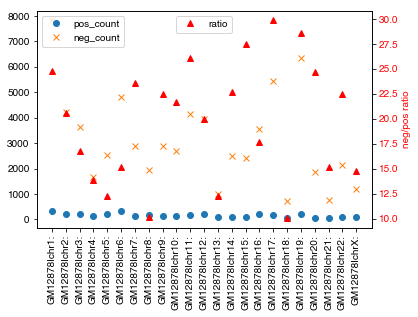

1
2
3
4
[('GM12878|chr12:', 'GM12878|chrX:', 'GM12878|chr15:'), ('GM12878|chr22:', 'GM12878|chr2:', 'GM12878|chr13:'), ('GM12878|chr22:', 'GM12878|chr10:', 'GM12878|chr14:', 'GM12878|chr18:'), ('GM12878|chr15:', 'GM12878|chr2:', 'GM12878|chr18:'), ('GM12878|chrX:', 'GM12878|chr22:', 'GM12878|chr13:', 'GM12878|chr11:'), ('GM12878|chrX:', 'GM12878|chr7:', 'GM12878|chr13:', 'GM12878|chr20:'), ('GM12878|chrX:', 'GM12878|chr7:', 'GM12878|chr13:', 'GM12878|chr14:'), ('GM12878|chr15:', 'GM12878|chr21:', 'GM12878|chr2:', 'GM12878|chr18:'), ('GM12878|chrX:', 'GM12878|chr15:', 'GM12878|chr13:', 'GM12878|chr14:'), ('GM12878|chr15:', 'GM12878|chr7:', 'GM12878|chr13:', 'GM12878|chr18:'), ('GM12878|chrX:', 'GM12878|chr15:', 'GM12878|chr7:', 'GM12878|chr18:'), ('GM12878|chr7:', 'GM12878|chr9:', 'GM12878|chr4:'), ('GM12878|chr3:', 'GM12878|chr22:', 'GM12878|chr20:'), ('GM12878|chr21:', 'GM12878|chr7:', 'GM12878|chr13:', 'GM12878|chr9:'), ('GM12878|chrX:', 'GM12878|chr15:', 'GM12878|chr9:', 'GM12878|ch

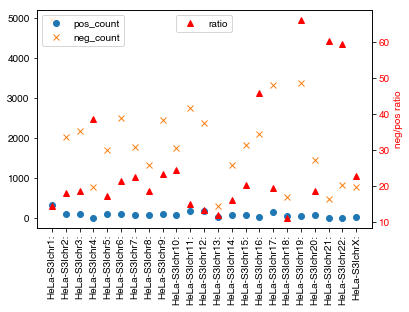

1
2
3
4
[('HeLa-S3|chr5:', 'HeLa-S3|chr13:', 'HeLa-S3|chr22:', 'HeLa-S3|chr20:'), ('HeLa-S3|chr7:', 'HeLa-S3|chr3:', 'HeLa-S3|chr4:', 'HeLa-S3|chr13:'), ('HeLa-S3|chr18:', 'HeLa-S3|chr15:', 'HeLa-S3|chr22:', 'HeLa-S3|chr20:'), ('HeLa-S3|chr18:', 'HeLa-S3|chr4:', 'HeLa-S3|chr14:', 'HeLa-S3|chr9:'), ('HeLa-S3|chr18:', 'HeLa-S3|chr7:', 'HeLa-S3|chr9:'), ('HeLa-S3|chr10:', 'HeLa-S3|chr13:', 'HeLa-S3|chr8:', 'HeLa-S3|chr20:'), ('HeLa-S3|chr7:', 'HeLa-S3|chr15:', 'HeLa-S3|chr20:'), ('HeLa-S3|chr10:', 'HeLa-S3|chr18:', 'HeLa-S3|chr5:', 'HeLa-S3|chr4:'), ('HeLa-S3|chr10:', 'HeLa-S3|chr5:', 'HeLa-S3|chr4:', 'HeLa-S3|chr13:'), ('HeLa-S3|chrX:', 'HeLa-S3|chr21:', 'HeLa-S3|chr14:', 'HeLa-S3|chr15:'), ('HeLa-S3|chr16:', 'HeLa-S3|chr13:', 'HeLa-S3|chr12:'), ('HeLa-S3|chr4:', 'HeLa-S3|chr13:', 'HeLa-S3|chr14:', 'HeLa-S3|chr15:'), ('HeLa-S3|chr10:', 'HeLa-S3|chr18:', 'HeLa-S3|chr7:', 'HeLa-S3|chrX:'), ('HeLa-S3|chrX:', 'HeLa-S3|chr5:', 'HeLa-S3|chr21:', 'HeLa-S3|chr14:'), ('HeLa-S3|chr2:', 'HeLa-S3|ch

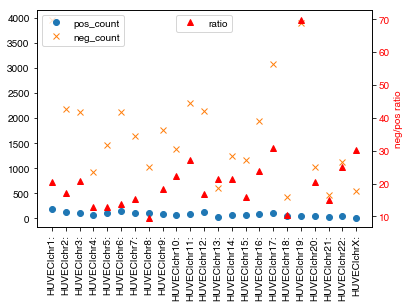

1
2
3
4
[('HUVEC|chrX:', 'HUVEC|chr16:', 'HUVEC|chr21:', 'HUVEC|chr15:'), ('HUVEC|chrX:', 'HUVEC|chr16:', 'HUVEC|chr7:'), ('HUVEC|chr13:', 'HUVEC|chr3:', 'HUVEC|chr9:'), ('HUVEC|chrX:', 'HUVEC|chr20:', 'HUVEC|chr2:'), ('HUVEC|chr11:', 'HUVEC|chr20:', 'HUVEC|chr4:'), ('HUVEC|chr13:', 'HUVEC|chrX:', 'HUVEC|chr3:', 'HUVEC|chr15:'), ('HUVEC|chr22:', 'HUVEC|chr20:', 'HUVEC|chr3:', 'HUVEC|chr21:'), ('HUVEC|chr20:', 'HUVEC|chr10:', 'HUVEC|chr14:', 'HUVEC|chr18:'), ('HUVEC|chr11:', 'HUVEC|chrX:', 'HUVEC|chr5:'), ('HUVEC|chr22:', 'HUVEC|chr14:', 'HUVEC|chr7:'), ('HUVEC|chrX:', 'HUVEC|chr14:', 'HUVEC|chr2:'), ('HUVEC|chrX:', 'HUVEC|chr8:', 'HUVEC|chr17:'), ('HUVEC|chr3:', 'HUVEC|chr10:', 'HUVEC|chr18:'), ('HUVEC|chrX:', 'HUVEC|chr20:', 'HUVEC|chr3:', 'HUVEC|chr18:'), ('HUVEC|chr22:', 'HUVEC|chrX:', 'HUVEC|chr10:', 'HUVEC|chr4:'), ('HUVEC|chrX:', 'HUVEC|chr10:', 'HUVEC|chr21:', 'HUVEC|chr9:'), ('HUVEC|chr13:', 'HUVEC|chr16:', 'HUVEC|chr10:', 'HUVEC|chr18:'), ('HUVEC|chrX:', 'HUVEC|chr16:', 'HUVEC

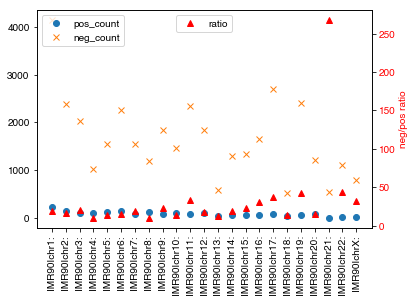

1
2
3
4
[('IMR90|chr8:', 'IMR90|chr22:', 'IMR90|chr16:'), ('IMR90|chr8:', 'IMR90|chr22:', 'IMR90|chr21:', 'IMR90|chr14:'), ('IMR90|chr9:', 'IMR90|chr8:', 'IMR90|chr21:', 'IMR90|chrX:'), ('IMR90|chr22:', 'IMR90|chr4:', 'IMR90|chr7:', 'IMR90|chrX:'), ('IMR90|chr15:', 'IMR90|chr10:', 'IMR90|chr16:'), ('IMR90|chr9:', 'IMR90|chr3:', 'IMR90|chr13:'), ('IMR90|chr19:', 'IMR90|chr8:', 'IMR90|chr18:'), ('IMR90|chr15:', 'IMR90|chr4:', 'IMR90|chr16:'), ('IMR90|chr4:', 'IMR90|chr21:', 'IMR90|chr16:', 'IMR90|chr13:'), ('IMR90|chr9:', 'IMR90|chr22:', 'IMR90|chr5:'), ('IMR90|chr20:', 'IMR90|chr22:', 'IMR90|chr18:', 'IMR90|chr14:'), ('IMR90|chr10:', 'IMR90|chr22:', 'IMR90|chrX:', 'IMR90|chr13:'), ('IMR90|chr5:', 'IMR90|chr18:', 'IMR90|chr11:'), ('IMR90|chr12:', 'IMR90|chr7:', 'IMR90|chrX:'), ('IMR90|chr15:', 'IMR90|chr20:', 'IMR90|chrX:', 'IMR90|chr14:'), ('IMR90|chr20:', 'IMR90|chr21:', 'IMR90|chr7:', 'IMR90|chr18:'), ('IMR90|chr21:', 'IMR90|chrX:', 'IMR90|chr6:', 'IMR90|chr13:'), ('IMR90|chr15:', 'IM

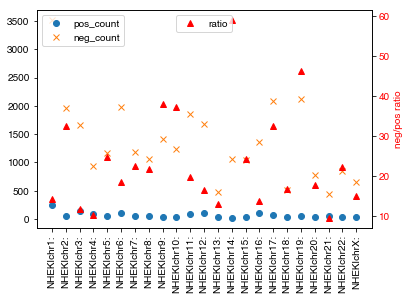

1
2
3
4
[('NHEK|chr13:', 'NHEK|chr11:', 'NHEK|chr15:'), ('NHEK|chr12:', 'NHEK|chrX:', 'NHEK|chr10:'), ('NHEK|chr11:', 'NHEK|chr5:', 'NHEK|chr20:'), ('NHEK|chr8:', 'NHEK|chr5:', 'NHEK|chr18:', 'NHEK|chr20:'), ('NHEK|chr6:', 'NHEK|chr5:', 'NHEK|chr18:'), ('NHEK|chr12:', 'NHEK|chr14:', 'NHEK|chr13:', 'NHEK|chr18:'), ('NHEK|chr21:', 'NHEK|chr11:', 'NHEK|chr10:'), ('NHEK|chr14:', 'NHEK|chr5:', 'NHEK|chr4:', 'NHEK|chr18:'), ('NHEK|chr21:', 'NHEK|chr6:', 'NHEK|chr10:'), ('NHEK|chr10:', 'NHEK|chr4:', 'NHEK|chr15:'), ('NHEK|chr13:', 'NHEK|chr5:', 'NHEK|chr20:', 'NHEK|chr7:'), ('NHEK|chr11:', 'NHEK|chr18:', 'NHEK|chr7:'), ('NHEK|chr21:', 'NHEK|chr5:', 'NHEK|chr7:', 'NHEK|chr22:'), ('NHEK|chr16:', 'NHEK|chr14:', 'NHEK|chr20:'), ('NHEK|chr13:', 'NHEK|chr20:', 'NHEK|chr7:', 'NHEK|chr22:'), ('NHEK|chr12:', 'NHEK|chr14:', 'NHEK|chrX:'), ('NHEK|chr21:', 'NHEK|chr13:', 'NHEK|chr2:', 'NHEK|chr22:'), ('NHEK|chr21:', 'NHEK|chrX:', 'NHEK|chr9:', 'NHEK|chr20:'), ('NHEK|chr21:', 'NHEK|chr13:', 'NHEK|chr9:', 

In [7]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    all_scores = {}
    for cell in cells:
        all_scores[cell] = run_for_cell(cell)

In [8]:
import pickle
with open("all_scores_eep.pickle", 'wb') as out:
    pickle.dump(all_scores, out)

In [9]:
import pickle
all_scores = pickle.load(open('all_scores_eep.pickle', 'rb'))

In [10]:
def get_baseline(mode):
    a = [0]*10000 + [1] * 500
    baselines = []
    for _ in range(1000):
        b_pos = np.random.rand(500) / 2 + 0.5
        b_neg = np.random.rand(10000) / 2

        b = np.concatenate((b_pos, b_neg), axis=0)
        np.random.shuffle(b)
        #b = np.random.rand(len(a))
        #b = np.ones(len(a))

        if mode == 'f1':
            baselines.append(f1_score(a,shuffle(a)))
        elif mode == 'accuracy':
            baselines.append(accuracy_score(a,shuffle(a)))
        elif mode == 'auprc':
            baselines.append(average_precision_score(a,b))
        elif mode == 'auroc':
            baselines.append(roc_auc_score(a,b))
        
    return np.mean(baselines)

f1_baseline = 2/23
auprc_baseline = 1 / 21
auroc_baseline = 0.5
accuracy_baseline = max((20*20/21+1/21)/21, 0.5)
baselines = (f1_baseline, auprc_baseline, auroc_baseline, accuracy_baseline)
print(baselines)

(0.08695652173913043, 0.047619047619047616, 0.5, 0.909297052154195)


In [11]:
a = np.array([0] * 10000 + [1] * 500)
np.sum(a == shuffle(a)) / 10500

0.90933333333333333

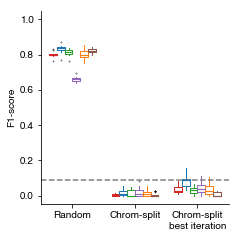

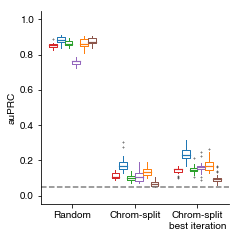

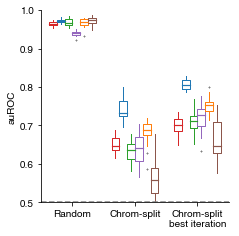

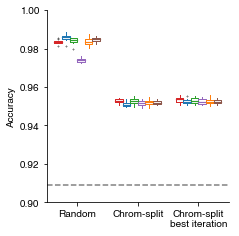

In [12]:

offsets = [-3, -2, -1, 0, 1, 2]
width = 0.125
names = ['F1-score', 'auPRC', 'auROC','Accuracy']
for i,name in enumerate(names):
    fig = plt.figure(figsize=(col1Width, col1Width))
    ax = fig.add_subplot(1,1,1)
    flierprops = dict(marker='+', color="#aaaaaa", markersize=2, alpha=0.5)
    all_boxes = []
    for idx, cell in enumerate(cells):
        offset = offsets[idx] * width + 0.5*width
        box = ax.boxplot([[x[2][-1,i] for x in all_scores[cell][0]],
                          [x[2][-1,i] for x in all_scores[cell][1]],
                          [np.max(x[2][:,i]) for x in all_scores[cell][1]]],
                    positions=[1+offset, 2+offset, 3+offset], widths=0.125,
                    notch=False, flierprops=flierprops)
        all_boxes.append(box)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Random', 'Chrom-split', 'Chrom-split\nbest iteration'])

    ax.set_xlim([0.5,3.5])
    if i == 2:
        ax.set_ylim([0.5, 1.0])
    elif i == 3:
        ax.set_ylim([0.9, 1.0])
    else:
        ax.set_ylim([-0.05, 1.05])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(y=baselines[i], linestyle='--', color='gray')
    ax.tick_params(axis='x', direction='out', top='off')
    ax.tick_params(axis='y', direction='out', right='off')
    for j in range(len(all_boxes)):
        box = all_boxes[j]
        curr_color = colors[j*2]
        for i in range(3):

            #box['boxes'][i].set_facecolor(curr_color)
            box['boxes'][i].set_color(curr_color)

            box['whiskers'][i * 2].set_color(curr_color)
            box['whiskers'][i * 2 + 1].set_color(curr_color)
            box['whiskers'][i * 2].set_linewidth(1)
            box['whiskers'][i * 2 + 1].set_linewidth(1)
            box['whiskers'][i * 2].set_linestyle('-')
            box['whiskers'][i * 2 + 1].set_linestyle('-')

            box['medians'][i].set_color(curr_color)
            box['medians'][i].set_linewidth(1.2)

            box['caps'][i * 2].set_color(curr_color)
            box['caps'][i * 2 + 1].set_color(curr_color)
        for c in box['caps']:
            c.set_linewidth(0)
    ax.set_ylabel(name)
    #ax.set_xlabel('')
    fig.tight_layout()
    fig.savefig("targetfinder_split_by_chrom_performance_{}_eep.pdf".format(name.split('-')[0].lower()), dpi=600)
    fig.savefig("targetfinder_split_by_chrom_performance_{}_eep.png".format(name.split('-')[0].lower()), dpi=600)

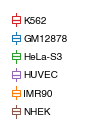

In [13]:
inch = 25.4
col1Width = 87 / inch
offsets = [-3, -2, -1, 0, 1, 2]
width = 0.1
fig = plt.figure(figsize=(col1Width/3.8, col1Width/2.2), frameon=False)
ax = fig.add_subplot(1,1,1)
flierprops = dict(marker='+', color="#aaaaaa", markersize=2, alpha=0.5)
all_boxes = []
for idx, cell in enumerate(cells):
    offset = offsets[idx] * width + 0.5*width
    box = ax.boxplot([[-2*idx+0.7,-idx*2,-2*idx-0.7]],
                positions=[1,], widths=width,
                notch=False, flierprops=flierprops)
    ax.text(1+width, -idx*2-0.4, cell)
    all_boxes.append(box)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_xticklabels(['Random', '2-chrom', '2-chrom\nbest iteration'])

ax.set_xlim([0.93, 1.78])
ax.set_ylim([-11, 1.])


ax.tick_params(axis='x', direction='out', top='off', bottom='off')
ax.tick_params(axis='y', direction='out', right='off', left='off')
for j in range(len(all_boxes)):
    box = all_boxes[j]
    curr_color = colors[j*2]
    for i in range(1):
        
        #box['boxes'][i].set_facecolor(curr_color)
        box['boxes'][i].set_color(curr_color)

        box['whiskers'][i * 2].set_color(curr_color)
        box['whiskers'][i * 2 + 1].set_color(curr_color)
        box['whiskers'][i * 2].set_linewidth(1)
        box['whiskers'][i * 2 + 1].set_linewidth(1)
        box['whiskers'][i * 2].set_linestyle('-')
        box['whiskers'][i * 2 + 1].set_linestyle('-')

        box['medians'][i].set_color(curr_color)
        box['medians'][i].set_linewidth(1.2)

        box['caps'][i * 2].set_color(curr_color)
        box['caps'][i * 2 + 1].set_color(curr_color)
    for c in box['caps']:
        c.set_linewidth(0)
ax.axis('off')
#ax.set_ylabel("F1-score")
#ax.set_xlabel('')
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99,
                wspace=None, hspace=None)
#fig.tight_layout()

fig.savefig("targetfinder_cell_boxplot_legend.pdf", dpi=600)
fig.savefig("targetfinder_cell_boxplot_legend.png", dpi=600)

In [14]:
for i in range(4):
    for c in cells:
        print(c + "\t" + "\t".join(map(str, [x[2][-1,i] for x in all_scores[c][0]])))
    print()

K562	0.799163179916	0.800838574423	0.796680497925	0.791489361702	0.802494802495	0.795744680851	0.80658436214	0.830265848671	0.766595289079	0.823770491803
GM12878	0.844583987441	0.824074074074	0.813990461049	0.771241830065	0.835680751174	0.84	0.84437596302	0.834123222749	0.850863422292	0.871951219512
HeLa-S3	0.8	0.827586206897	0.817941952507	0.832041343669	0.821989528796	0.83709273183	0.802083333333	0.761904761905	0.815789473684	0.807387862797
HUVEC	0.643312101911	0.660194174757	0.668810289389	0.660130718954	0.696202531646	0.648829431438	0.651898734177	0.662337662338	0.673139158576	0.640522875817
IMR90	0.77811550152	0.857142857143	0.847058823529	0.804804804805	0.793846153846	0.792682926829	0.812121212121	0.753164556962	0.826979472141	0.787878787879
NHEK	0.826086956522	0.838709677419	0.817518248175	0.795698924731	0.812720848057	0.829787234043	0.833333333333	0.841726618705	0.810035842294	0.815884476534

K562	0.855284478949	0.855616053071	0.839674199097	0.837623546226	0.852570931249	0.8500

In [15]:
for c in cells:
    print(c)
    for x in all_scores[c][1]:
        print(x[0], 
              x[1][-1,0], x[2][-1,0], x[1][np.argmax(x[2][:,0]),0], np.max(x[2][:,0]), np.argmax(x[2][:,0]), 
              x[1][-1,1], x[2][-1,1], x[1][np.argmax(x[2][:,1]),1], np.max(x[2][:,1]), np.argmax(x[2][:,0]), 
              x[1][-1,2], x[2][-1,2], x[1][np.argmax(x[2][:,2]),2], np.max(x[2][:,2]), np.argmax(x[2][:,0]), 
              x[1][-1,3], x[2][-1,3], x[1][np.argmax(x[2][:,3]),3], np.max(x[2][:,3]), np.argmax(x[2][:,0]), 
              sep='\t')

K562
('K562|chr21:', 'K562|chr5:', 'K562|chr20:', 'K562|chr3:')	1.0	0.00613496932515	0.671009771987	0.0298507462687	216	1.0	0.109650510963	0.662289642019	0.147025612385	216	1.0	0.633571816099	0.863881404425	0.709852392439	216	1.0	0.951278195489	0.999315068493	0.951578947368	216
('K562|chr2:', 'K562|chrX:', 'K562|chr4:', 'K562|chr8:')	1.0	0.0066889632107	0.752715332155	0.0705128205128	287	1.0	0.144879421563	0.845427462491	0.150054961035	287	1.0	0.652673963363	0.911104591197	0.683845105933	287	1.0	0.954102920723	0.980908364048	0.955184670066	287
('K562|chr7:', 'K562|chr5:', 'K562|chr20:', 'K562|chr18:')	1.0	0.00617283950617	0.633101529903	0.0463768115942	196	1.0	0.12620630184	0.679745973808	0.150447423629	196	1.0	0.670665813541	0.930688090586	0.711875962999	196	1.0	0.952239691486	0.952340809285	0.952684663305	196
('K562|chr15:', 'K562|chr22:', 'K562|chrX:', 'K562|chr3:')	1.0	0.0128205128205	0.789990186457	0.0185758513932	319	1.0	0.0913048186955	0.661063762263	0.102602030296	319	1.0	0.639

In [13]:



all_means = []
for idx, cell in enumerate(cells):
    training_df = pd.read_hdf('paper/targetfinder/{}/output-eep/training.h5'.format(cell), 
                              'training').set_index(['enhancer_name', 'promoter_name'])
    predictors_df = training_df.drop(nonpredictors, axis = 1)
    all_means.append((predictors_df>0).mean())
    


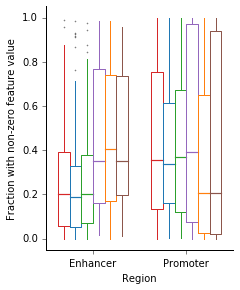

In [17]:
inch = 25.4
col1Width = 87 / inch
offsets = [-3, -2, -1, 0, 1, 2]
width = 0.125
fig = plt.figure(figsize=(col1Width, col1Width*1.2))
ax = fig.add_subplot(1,1,1)
flierprops = dict(marker='+', color="#aaaaaa", markersize=2, alpha=0.5)
all_boxes = []
for idx, percent_with_data in enumerate(all_means):
    offset = offsets[idx] * width + 0.5*width
    box = ax.boxplot([percent_with_data[[i for i in percent_with_data.index if i.endswith('(enhancer)')]],
                 #percent_with_data[[i for i in percent_with_data.index if i.endswith('(window)')]],
                 percent_with_data[[i for i in percent_with_data.index if i.endswith('(promoter)')]]],
                positions=[1+offset, 2+offset], widths=0.125,
                notch=False, flierprops=flierprops)
    all_boxes.append(box)
ax.set_xticks([1,2])
ax.set_xticklabels(['Enhancer', 'Promoter'])

ax.set_xlim([0.5,2.5])
ax.set_ylim([-0.05, 1.05])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', direction='out', top='off')
ax.tick_params(axis='y', direction='out', right='off')
for j in range(len(all_boxes)):
    box = all_boxes[j]
    curr_color = colors[j*2]
    for i in range(2):
        
        #box['boxes'][i].set_facecolor(curr_color)
        box['boxes'][i].set_color(curr_color)

        box['whiskers'][i * 2].set_color(curr_color)
        box['whiskers'][i * 2 + 1].set_color(curr_color)
        box['whiskers'][i * 2].set_linewidth(1)
        box['whiskers'][i * 2 + 1].set_linewidth(1)
        box['whiskers'][i * 2].set_linestyle('-')
        box['whiskers'][i * 2 + 1].set_linestyle('-')

        box['medians'][i].set_color(curr_color)
        box['medians'][i].set_linewidth(1.2)

        box['caps'][i * 2].set_color(curr_color)
        box['caps'][i * 2 + 1].set_color(curr_color)
    for c in box['caps']:
        c.set_linewidth(0)
ax.set_ylabel("Fraction with non-zero feature value")
ax.set_xlabel('Region')
fig.tight_layout()
#fig.savefig("targetfinder_fraction_with_non_zero_feature_value.pdf", dpi=600)
#fig.savefig("targetfinder_fraction_with_non_zero_feature_value.jpg", dpi=600)

In [5]:
cells

['K562', 'GM12878', 'HeLa-S3', 'HUVEC', 'IMR90', 'NHEK']

In [10]:
from sklearn.metrics import mean_absolute_error


In [11]:
def get_error_for_cell(cell, frac):
    print(cell, frac)
    training_df = pd.read_hdf('paper/targetfinder/{}/output-eep/training.h5'.format(cell), 
                                  'training').set_index('window_name')
    predictors_df = training_df.sort_values(['enhancer_chrom', 
                                             'enhancer_start', 
                                             'enhancer_end']).ix[:, 
                                                                 ['enhancer_name']
                                                                 +[n for n in training_df.columns if n.endswith('(enhancer)')]]

    pos_predictors_df = predictors_df.loc[training_df.loc[:, 'label']==1, :].drop_duplicates(subset='enhancer_name', keep='first').set_index('enhancer_name')
    neg_predictors_df = predictors_df.loc[training_df.loc[:, 'label']==0, :].drop_duplicates(subset='enhancer_name', keep='first').set_index('enhancer_name')

    pairs = []
    pairs_index = []
    with open("{}/output-eep/overlap_pos_pos_0.{}_pairs.txt".format(cell, frac)) as f:
        pos_indexes = pos_predictors_df.index
        for r in f:
            pairs.append(r.strip().split())
            pairs_index.append([pos_predictors_df.index.get_loc(pairs[-1][0]), 
                                pos_predictors_df.index.get_loc(pairs[-1][1])])
    temp = sorted(np.random.choice(len(pos_predictors_df)*(len(pos_predictors_df)-1)//2,  len(pairs), replace=False))
    ticker = 0
    pointer = 0
    random_pairs = []
    for i in range(len(pos_predictors_df)-1):
        for j in range(i+1, len(pos_predictors_df)):
            if ticker == temp[pointer]:
                random_pairs.append([i,j])
                pointer += 1
            if pointer >= len(temp):
                break
            ticker += 1
        if pointer >= len(temp):
            break
    print(len(random_pairs), len(pairs))

    from sklearn.metrics import mean_absolute_error
    pair_errors = [mean_absolute_error(pos_predictors_df.iloc[p[0],:], 
                                       pos_predictors_df.iloc[p[1],:]) for p in pairs_index]
    random_pair_errors = [mean_absolute_error(pos_predictors_df.iloc[p[0],:], 
                                              pos_predictors_df.iloc[p[1],:]) for p in random_pairs]
    return pair_errors, random_pair_errors

In [12]:
all_errors = {}
for cell in cells:
    all_errors[cell] = []
    for i in list(range(1, 10)):
        all_errors[cell].append(get_error_for_cell(cell, i))
import pickle
with open("all_errors_eep.pickle", 'wb') as out:
    pickle.dump(all_errors, out)

K562 1
2825 2825
K562 2
2615 2615
K562 3
2385 2385
K562 4
2164 2164
K562 5
1903 1903
K562 6
1589 1589
K562 7
1298 1298
K562 8
918 918
K562 9
489 489
GM12878 1
5073 5073
GM12878 2
4778 4778
GM12878 3
4431 4431
GM12878 4
4028 4028
GM12878 5
3539 3539
GM12878 6
3027 3027
GM12878 7
2416 2416
GM12878 8
1673 1673
GM12878 9
759 759
HeLa-S3 1
2878 2878
HeLa-S3 2
2679 2679
HeLa-S3 3
2431 2431
HeLa-S3 4
2172 2172
HeLa-S3 5
1898 1898
HeLa-S3 6
1600 1600
HeLa-S3 7
1266 1266
HeLa-S3 8
865 865
HeLa-S3 9
388 388
HUVEC 1
1264 1264
HUVEC 2
1174 1174
HUVEC 3
1076 1076
HUVEC 4
953 953
HUVEC 5
823 823
HUVEC 6
704 704
HUVEC 7
539 539
HUVEC 8
357 357
HUVEC 9
150 150
IMR90 1
2771 2771
IMR90 2
2604 2604
IMR90 3
2405 2405
IMR90 4
2174 2174
IMR90 5
1952 1952
IMR90 6
1643 1643
IMR90 7
1355 1355
IMR90 8
988 988
IMR90 9
527 527
NHEK 1
2198 2198
NHEK 2
2091 2091
NHEK 3
1940 1940
NHEK 4
1788 1788
NHEK 5
1614 1614
NHEK 6
1413 1413
NHEK 7
1198 1198
NHEK 8
910 910
NHEK 9
472 472


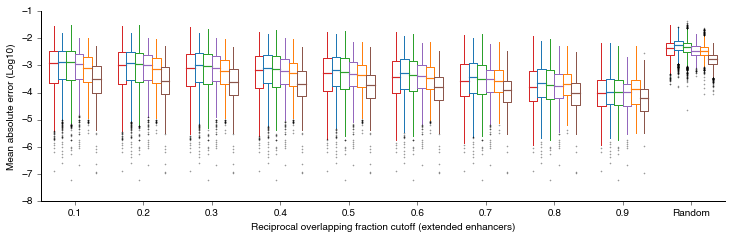

In [24]:
all_errors = pickle.load(open('all_errors_eep.pickle', 'rb'))
fracs = list(range(1,10))
inch = 25.4
col1Width = 87 / inch
offsets = [-3, -2, -1, 0, 1, 2]
width = 0.125
fig = plt.figure(figsize=(col1Width*3, col1Width))
ax = fig.add_subplot(1,1,1)
all_boxes = []
flierprops = dict(marker='+', color="#aaaaaa", markersize=2, alpha=0.4)
for idx, cell in enumerate(cells):
    offset = offsets[idx] * width + 0.5*width
    box = ax.boxplot([np.log10(x[0]) for x in all_errors[cell]] 
                      +[np.log10(all_errors[cell][0][1])],
                    positions=np.arange(1,len(fracs) +2) + offset, widths=0.125,
                    notch=False, flierprops=flierprops)
    all_boxes.append(box)
ax.set_xticks(np.arange(1,11))
ax.set_xticklabels(['0.{}'.format(x) for x in fracs] + ['Random'])

ax.set_xlim([0.5,len(fracs)+1.5])
#ax.set_ylim([-7, -1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', direction='out', top='off')
ax.tick_params(axis='y', direction='out', right='off')


for j in range(len(all_boxes)):
    box = all_boxes[j]
    curr_color = colors[j*2]
    for i in range(len(fracs)+1):
        
        #box['boxes'][i].set_facecolor(curr_color)
        box['boxes'][i].set_color(curr_color)

        box['whiskers'][i * 2].set_color(curr_color)
        box['whiskers'][i * 2 + 1].set_color(curr_color)
        box['whiskers'][i * 2].set_linewidth(1)
        box['whiskers'][i * 2 + 1].set_linewidth(1)
        box['whiskers'][i * 2].set_linestyle('-')
        box['whiskers'][i * 2 + 1].set_linestyle('-')

        box['medians'][i].set_color(curr_color)
        box['medians'][i].set_linewidth(1.2)

        box['caps'][i * 2].set_color(curr_color)
        box['caps'][i * 2 + 1].set_color(curr_color)
    for c in box['caps']:
        c.set_linewidth(0)
ax.set_ylabel("Mean absolute error (Log10)")
ax.set_xlabel("Reciprocal overlapping fraction cutoff (extended enhancers)")
fig.tight_layout()
fig.savefig("targetfinder_mean_absolute_error_between_pos_pairs_eep_all.pdf", dpi=600)
fig.savefig("targetfinder_mean_absolute_error_between_pos_pairs_eep_all.png", dpi=600)

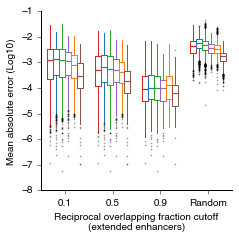

In [23]:
fracs = list(range(1,10))
inch = 25.4
col1Width = 87 / inch
offsets = [-3, -2, -1, 0, 1, 2]
width = 0.125
fig = plt.figure(figsize=(col1Width, col1Width))
ax = fig.add_subplot(1,1,1)
all_boxes = []
flierprops = dict(marker='+', color="#aaaaaa", markersize=2, alpha=0.4)
for idx, cell in enumerate(cells):
    offset = offsets[idx] * width + 0.5*width
    box = ax.boxplot([np.log10(x[0]) for x in [all_errors[cell][i] for i in [0,4,8]]]
                      +[np.log10(all_errors[cell][0][1])],
                    positions=np.arange(1,5) + offset, widths=0.125,
                    notch=False, flierprops=flierprops)
    all_boxes.append(box)
ax.set_xticks(np.arange(1,5))
ax.set_xticklabels(['0.{}'.format(x) for x in [1,5,9]] + ['Random'])

ax.set_xlim([0.5,4.5])
#ax.set_ylim([-7, -1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', direction='out', top='off')
ax.tick_params(axis='y', direction='out', right='off')


for j in range(len(all_boxes)):
    box = all_boxes[j]
    curr_color = colors[j*2]
    for i in range(4):
        
        #box['boxes'][i].set_facecolor(curr_color)
        box['boxes'][i].set_color(curr_color)

        box['whiskers'][i * 2].set_color(curr_color)
        box['whiskers'][i * 2 + 1].set_color(curr_color)
        box['whiskers'][i * 2].set_linewidth(1)
        box['whiskers'][i * 2 + 1].set_linewidth(1)
        box['whiskers'][i * 2].set_linestyle('-')
        box['whiskers'][i * 2 + 1].set_linestyle('-')

        box['medians'][i].set_color(curr_color)
        box['medians'][i].set_linewidth(1.2)

        box['caps'][i * 2].set_color(curr_color)
        box['caps'][i * 2 + 1].set_color(curr_color)
    for c in box['caps']:
        c.set_linewidth(0)
ax.set_ylabel("Mean absolute error (Log10)", fontsize=10)
ax.set_xlabel("Reciprocal overlapping fraction cutoff\n(extended enhancers)", fontsize=10)
fig.tight_layout()
fig.savefig("targetfinder_mean_absolute_error_between_pos_pairs_eep.pdf", dpi=600)
fig.savefig("targetfinder_mean_absolute_error_between_pos_pairs_eep.png", dpi=600)

In [38]:
for cell in cells:
    print(cell, end='\t')
    print('\t'.join(map(str, [np.median(all_errors[cell][i][0]) for i in range(len(all_errors[cell]))] + [np.median(all_errors[cell][0][1])])))

K562	0.00123969017427	0.000997466475444	0.000782699642521	0.000657098431098	0.000527954960345	0.000370922913745	0.000266946056777	0.000163816164709	9.26420939181e-05	0.00442823924517
GM12878	0.00137602358444	0.0011791732302	0.00100167500911	0.000833879712659	0.000669663325211	0.000516335848298	0.000368694199041	0.000233430842061	0.000100918298368	0.00547681345655
HeLa-S3	0.0013004340939	0.00115173692184	0.000949336136207	0.000725892933697	0.000564564245406	0.000426391888033	0.000315121322028	0.000193022546356	0.000102446686663	0.00471764404972
HUVEC	0.00116867726145	0.0010029251488	0.000834255784777	0.00063745083153	0.000493746695658	0.000410371192741	0.000313451651661	0.000181198193928	0.000102364953605	0.00358161199415
IMR90	0.000795443372842	0.000730593023331	0.000626102901786	0.000521164668163	0.0004405386142	0.000349840548274	0.000270227102535	0.000200629680531	0.000130535323109	0.00340335653825
NHEK	0.000304726923329	0.00027266640625	0.000237214537695	0.000204114688704	0.00018168

In [39]:
for cell in cells:
    print(cell, end='\t')
    print('\t'.join(map(str, [np.mean(all_errors[cell][i][0]) for i in range(len(all_errors[cell]))] + 
                        [np.mean(all_errors[cell][0][1])])))

K562	0.00227618764166	0.00207135478749	0.00188425648888	0.00168254840032	0.00145808246644	0.00116989637576	0.000957104492205	0.000627600187863	0.000366096389538	0.00550170372221
GM12878	0.00222724259389	0.00205930607946	0.00188434796843	0.00169447604581	0.00146866523847	0.00124998727786	0.000983718327684	0.000688919957645	0.000379235108242	0.00610191054396
HeLa-S3	0.0022757556506	0.00210518625133	0.00188362215433	0.00167349840636	0.00145503089133	0.00117390609697	0.00088936235349	0.000623233046813	0.000343607820572	0.00575876770187
HUVEC	0.00166925959945	0.00157123532449	0.00142587203912	0.00124150679054	0.000993057262541	0.000815160863947	0.00060434298021	0.000440074752083	0.000193994352499	0.00405361896007
IMR90	0.00132490911325	0.00122094987156	0.00110097433301	0.000965398903228	0.000830225103124	0.000674408642381	0.000553960685677	0.000425560693058	0.000303144482298	0.00402457855451
NHEK	0.000648604880864	0.00060069654652	0.000532278187607	0.000465267920991	0.000395283314452	0.0003

In [7]:
## Now considers the overlap between TargetFinder windows, with increasing overlapping fraction

overlap_data_frac_pp = pd.read_csv('eep_overlap_1_1_same_promoter.txt', sep=' ', names=['a_count', 'b_count', 'cell', 
                                                                       '1bp', '0.1', '0.2', '0.3', '0.4',
                                                                       '0.5', '0.6', '0.7', '0.8', '0.9', '0.99'])
overlap_data_frac_pp = overlap_data_frac_pp.set_index('cell')
overlap_data_frac_pn = pd.read_csv('eep_overlap_1_0_same_promoter.txt', sep=' ', names=['a_count', 'b_count', 'cell', 
                                                                       '1bp', '0.1', '0.2', '0.3', '0.4',
                                                                       '0.5', '0.6', '0.7', '0.8', '0.9', '0.99'])
overlap_data_frac_pn = overlap_data_frac_pn.set_index('cell')

In [21]:
cells

['K562', 'GM12878', 'HeLa-S3', 'HUVEC', 'IMR90', 'NHEK']

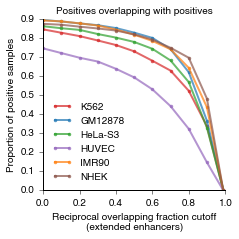

In [15]:
fig = plt.figure(figsize=(col1Width, col1Width))
ax = fig.add_subplot(111)
for i,cell in enumerate(cells):
    ax.plot([1e-9,] + list(np.arange(0.1, 0.99, 0.1)) + [0.99], 
             (overlap_data_frac_pp.ix[cell, 2:] / overlap_data_frac_pp.ix[cell,0]).values,
             color=colors[i*2], label=cell, linewidth=2, alpha=0.7, marker='.')

#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', top='off', direction='out')
ax.tick_params(axis='y', right='off', direction='out')
# Put a legend to the right of the current axis
ax.legend(loc='lower left', frameon=False, fontsize=10)
ax.set_title('Positives overlapping with positives', fontsize=10)

ax.set_xlabel('Reciprocal overlapping fraction cutoff\n(extended enhancers)', fontsize=10)
ax.set_ylabel('Proportion of positive samples', fontsize=10)
fig.tight_layout()
fig.savefig("targetfinder_fraction_change_with_increasing_overlapping_eep.pdf", dpi=600)
fig.savefig("targetfinder_fraction_change_with_increasing_overlapping_eep.png", dpi=600)

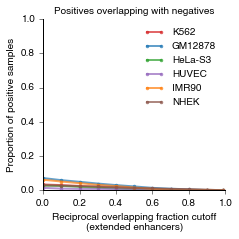

In [20]:
fig = plt.figure(figsize=(col1Width, col1Width))
ax = fig.add_subplot(111)

for i,cell in enumerate(cells):
    ax.plot([1e-9,] + list(np.arange(0.1, 0.99, 0.1)) + [0.99], 
             (overlap_data_frac_pn.ix[cell, 2:] / overlap_data_frac_pp.ix[cell,0]).values,
             color=colors[i*2], label=cell, linewidth=2, alpha=0.7, marker='.')
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', top='off', direction='out')
ax.tick_params(axis='y', right='off', direction='out')
# Put a legend to the right of the current axis
ax.legend(loc='upper right', frameon=False, fontsize=10)
ax.set_title('Positives overlapping with negatives', fontsize=10)
ax.set_ylim([0,1])
ax.set_xlabel('Reciprocal overlapping fraction cutoff\n(extended enhancers)', fontsize=10)
ax.set_ylabel('Proportion of positive samples', fontsize=10)
fig.tight_layout()
fig.savefig("targetfinder_fraction_change_with_increasing_overlapping_with_negs_eep.pdf", dpi=600)
fig.savefig("targetfinder_fraction_change_with_increasing_overlapping_with_negs_eep.png", dpi=600)